In [1]:
!pip install ipympl --quiet
!git clone https://github.com/bjam24/krs-web-scraper.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.6 MB/s eta 0:00:00
Cloning into 'krs-web-scraper'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 73 (delta 8), reused 18 (delta 5), pack-reused 44
Receiving objects: 100% (73/73), 11.37 MiB | 15.00 MiB/s, done.
Resolving deltas: 100% (22/22), done.


In [2]:
# uncomment to enable interactive plots


%matplotlib widget

from google.colab import output
output.enable_custom_widget_manager()

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

## Data import

In [3]:
all_files = glob.glob(os.path.join("/content/krs-web-scraper/data" , "*.csv"))

df = None
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

In [ ]:
df

,KRS,OrganizationName,LegalForm,Representatives,RepresentativesID,ConnectedOrganizations
0,75001,"""SIECHNICKI KLUB KYOKUSHIN KARATE""",stowarzyszenie kultury fizycznej,Marcin Kułakowski,988493,'PRINCEPS WROCŁAW KLUB KARATE KYOKUSHIN': '577...
1,75001,"""SIECHNICKI KLUB KYOKUSHIN KARATE""",stowarzyszenie kultury fizycznej,Sylwester Kowalczyk,923760,"'MIEJSKI KLUB SPORTOWY ""ŚLĘŻA"" SOBÓTKA': '4306..."
2,75001,"""SIECHNICKI KLUB KYOKUSHIN KARATE""",stowarzyszenie kultury fizycznej,Michał Jakubowski,163010,NaN
3,75001,"""SIECHNICKI KLUB KYOKUSHIN KARATE""",stowarzyszenie kultury fizycznej,Leszek Szuber,1280958,'PRINCEPS WROCŁAW KLUB KARATE KYOKUSHIN': '577...
4,75001,"""SIECHNICKI KLUB KYOKUSHIN KARATE""",stowarzyszenie kultury fizycznej,Artur Chądzel,1280959,NaN
...,...,...,...,...,...,...
366525,74998,"""SAMORZĄDNY NIEZALEŻNY ZWIĄZEK ZAWODOWY PRACOW...",związek zawodowy,Piotr Szydłowski,3154234,NaN
366526,74998,"""SAMORZĄDNY NIEZALEŻNY ZWIĄZEK ZAWODOWY PRACOW...",związek zawodowy,Janusz Jędrzejczak,1532356,NaN
366527,74998,"""SAMORZĄDNY NIEZALEŻNY ZWIĄZEK ZAWODOWY PRACOW...",związek zawodowy,Przemysław Kubicki,1404709,NaN
366528,74998,"""SAMORZĄDNY NIEZALEŻNY ZWIĄZEK ZAWODOWY PRACOW...",związek zawodowy,Karolina Ratajczak,1280957,NaN


## Company - person graph

In [4]:
G = nx.Graph()
person_color = 'red'
company_color = 'blue'

In [5]:
import re

def add_company_from_row(graph, row):
  krs_num = int(row[0])
  name = row[1]
  legal_form = row[2]
  if not graph.has_node(krs_num):
    graph.add_node(krs_num, name=name, legal_form=legal_form, color=company_color)

  return krs_num

def add_person_from_row(graph, row):
  person_id = "P" + str(row[4])
  name = row[3]
  if not graph.has_node(person_id):
    graph.add_node(person_id, color=person_color, name=name)

  return person_id

def add_relationship(graph, node1, node2):
  if not graph.has_edge(node1, node2):
    graph.add_edge(node1, node2)

def add_connected_org(graph, person_id, row):
  connected_org = row[5]
  if pd.isna(connected_org):
    return

  pattern = r"'(.*?)': '(\d*?)'"

  # Find all matches
  matches = re.findall(pattern, connected_org)

  result = {match[0]: int(match[1]) for match in matches}

  for name, company_id in result.items():
    if not graph.has_node(company_id):
      graph.add_node(company_id, name=name, legal_form='None', color=company_color)

    add_relationship(graph, company_id, person_id)

In [6]:
for index, row in df.iterrows():
    company_id = add_company_from_row(G, row)
    person_id = add_person_from_row(G,row)

    add_relationship(G, company_id, person_id)

    add_connected_org(G, person_id, row)

## Basic analysis

In [ ]:
def count_nodes_by_color(G, color_value):
    count = sum(1 for _, data in G.nodes(data=True) if data.get('color') == color_value)
    return count

company_color_count = count_nodes_by_color(G, company_color)
person_color_count = count_nodes_by_color(G, person_color)

print(f"companies: {company_color_count}")
print(f"persons': {person_color_count}")

companies: 150336
persons': 346013


In [ ]:
num_vertices = G.number_of_nodes()
num_edges = G.number_of_edges()

print("num_vertices", num_vertices)
print("num_edges", num_edges)

num_vertices 496349
num_edges 532702


In [ ]:
num_subgraphs = nx.number_connected_components(G)
print('Number of subgraphs:', num_subgraphs)


Number of subgraphs: 28488


In [ ]:
graphlet_sizes = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
print('Size of ten biggest subgraphs:', repr(graphlet_sizes[:10]))

Size of ten biggest subgraphs: [265328, 342, 197, 132, 131, 110, 105, 101, 90, 87]


In [ ]:
max_degree_node = max(G.nodes, key=lambda node: G.degree(node))

max_degree = G.degree(max_degree_node)

print("max_degree", max_degree)

max_degree 350


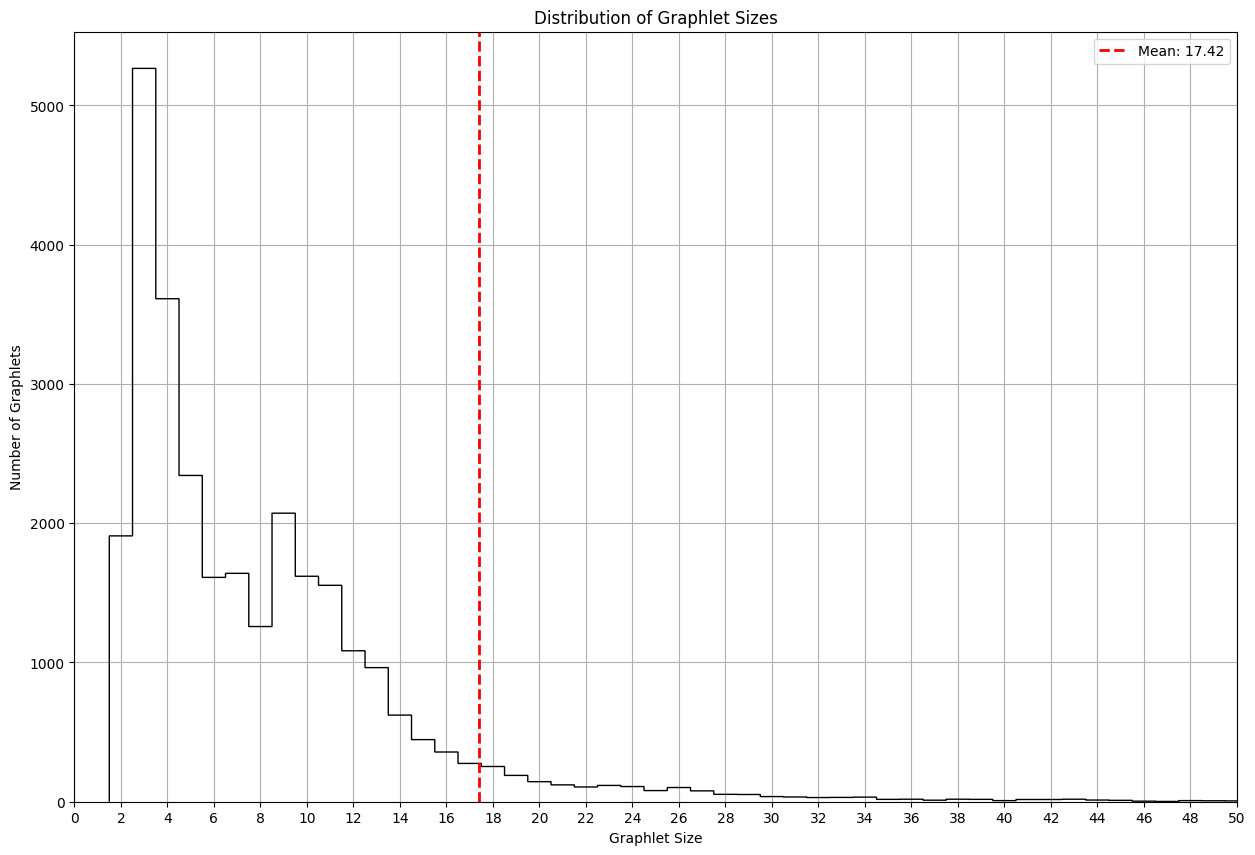

In [ ]:
# Counting graphlets
graphlet_sizes = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
mean_size = np.mean(graphlet_sizes)

plt.figure(figsize=(15, 10))

plt.hist(graphlet_sizes, bins=range(min(graphlet_sizes), max(graphlet_sizes) + 1, 1), edgecolor='black', histtype='step', align='left')
plt.axvline(mean_size, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_size:.2f}')

plt.xlabel('Graphlet Size')
plt.ylabel('Number of Graphlets')
plt.title('Distribution of Graphlet Sizes')
plt.xlim((0, 50))
plt.xticks(range(0, 51, 2))
plt.grid(True)
plt.legend()




plt.show()

## Largest subgraph

In [7]:
subgraph_nodes = sorted(nx.connected_components(G), key=len, reverse=True)[0]
subgraph = G.subgraph(subgraph_nodes)

num_nodes = subgraph.number_of_nodes()
num_edges = subgraph.number_of_edges()
average_degree = sum(dict(subgraph.degree()).values()) / num_nodes
density = nx.density(subgraph)

print(f'Number of nodes: {num_nodes}')
print(f'Number of edges: {num_edges}')
print(f'Average degree: {average_degree}')
print(f'Density: {density}')

Number of nodes: 265328
Number of edges: 319695
Average degree: 2.409809744919496
Density: 9.082414322400269e-06


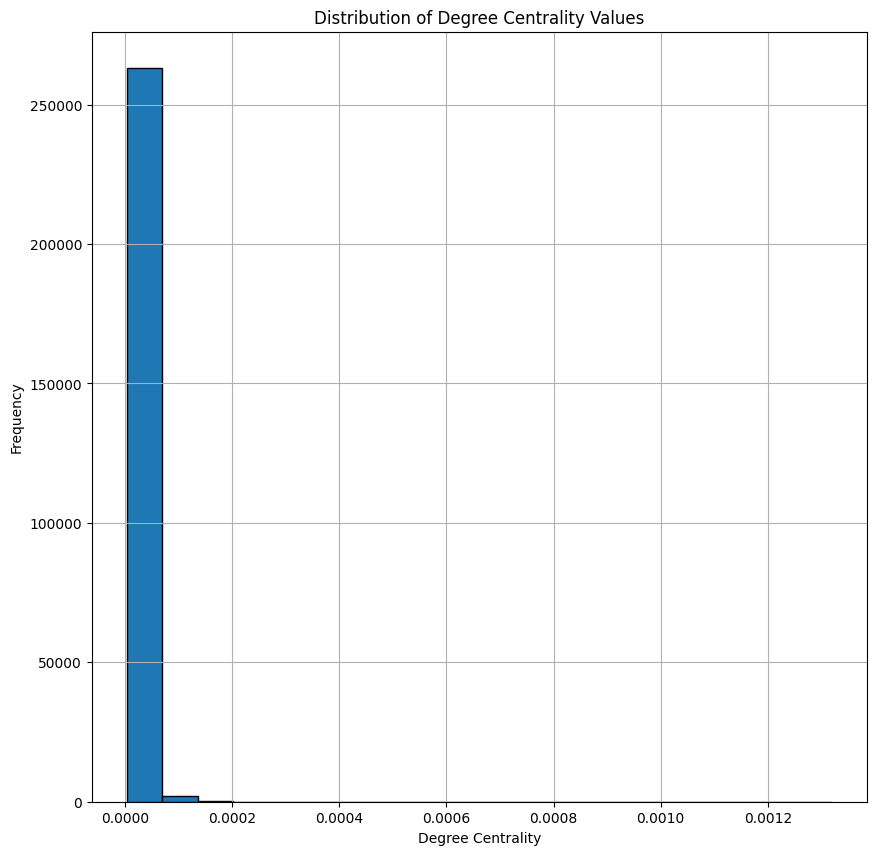

In [8]:
degree_centrality = nx.degree_centrality(subgraph)

plt.figure(figsize=(10, 10))
plt.hist(list(degree_centrality.values()), bins=20, edgecolor='black')
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.title('Distribution of Degree Centrality Values')
plt.grid(True)
plt.show()

In [9]:
!pip install igraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 31.7 MB/s eta 0:00:00


In [10]:
import igraph as ig
g = ig.Graph.from_networkx(subgraph)

In [11]:
cen = g.betweenness(cutoff=9)

In [12]:
betweenness_dict = {}
for vertex, centrality in zip(g.vs, cen):
    betweenness_dict[vertex["_nx_name"]] = centrality


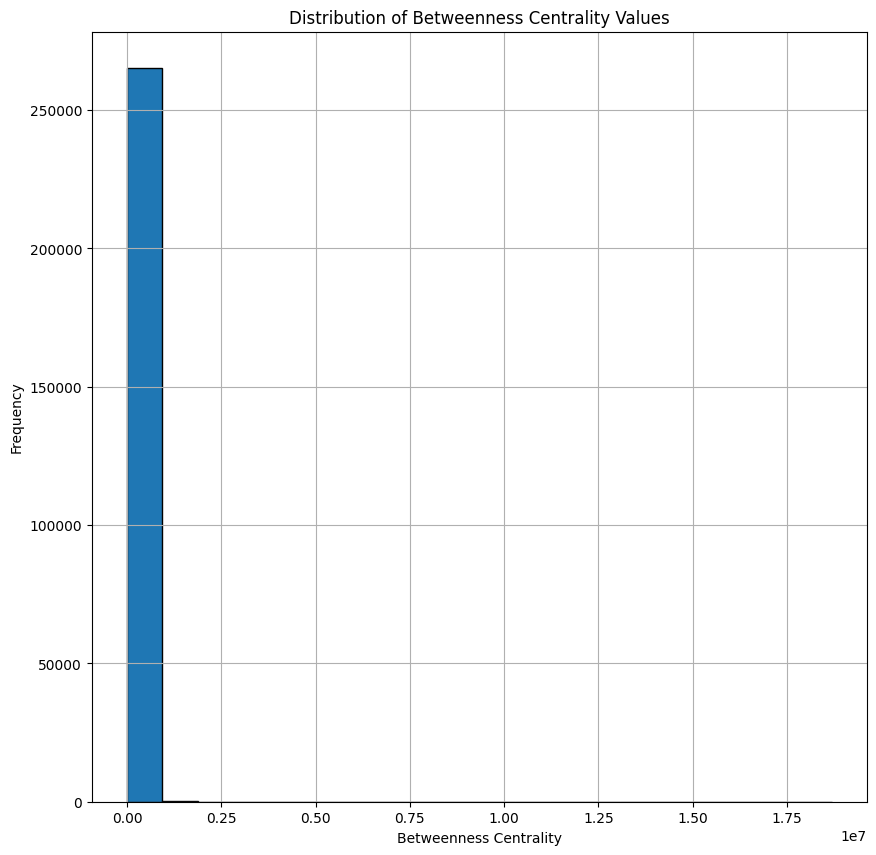

In [119]:
plt.figure(figsize=(10, 10))
plt.hist(list(betweenness_dict.values()), bins=20, edgecolor='black')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.title('Distribution of Betweenness Centrality Values')
plt.grid(True)
plt.show()

In [123]:
max_centrality_vertex = max(betweenness_dict, key=betweenness_dict.get)

neighbors = set()
for distance in range(1, 3):
    current_neighbors = set(nx.single_source_shortest_path_length(G, max_centrality_vertex, cutoff=distance).keys())
    neighbors.update(current_neighbors)

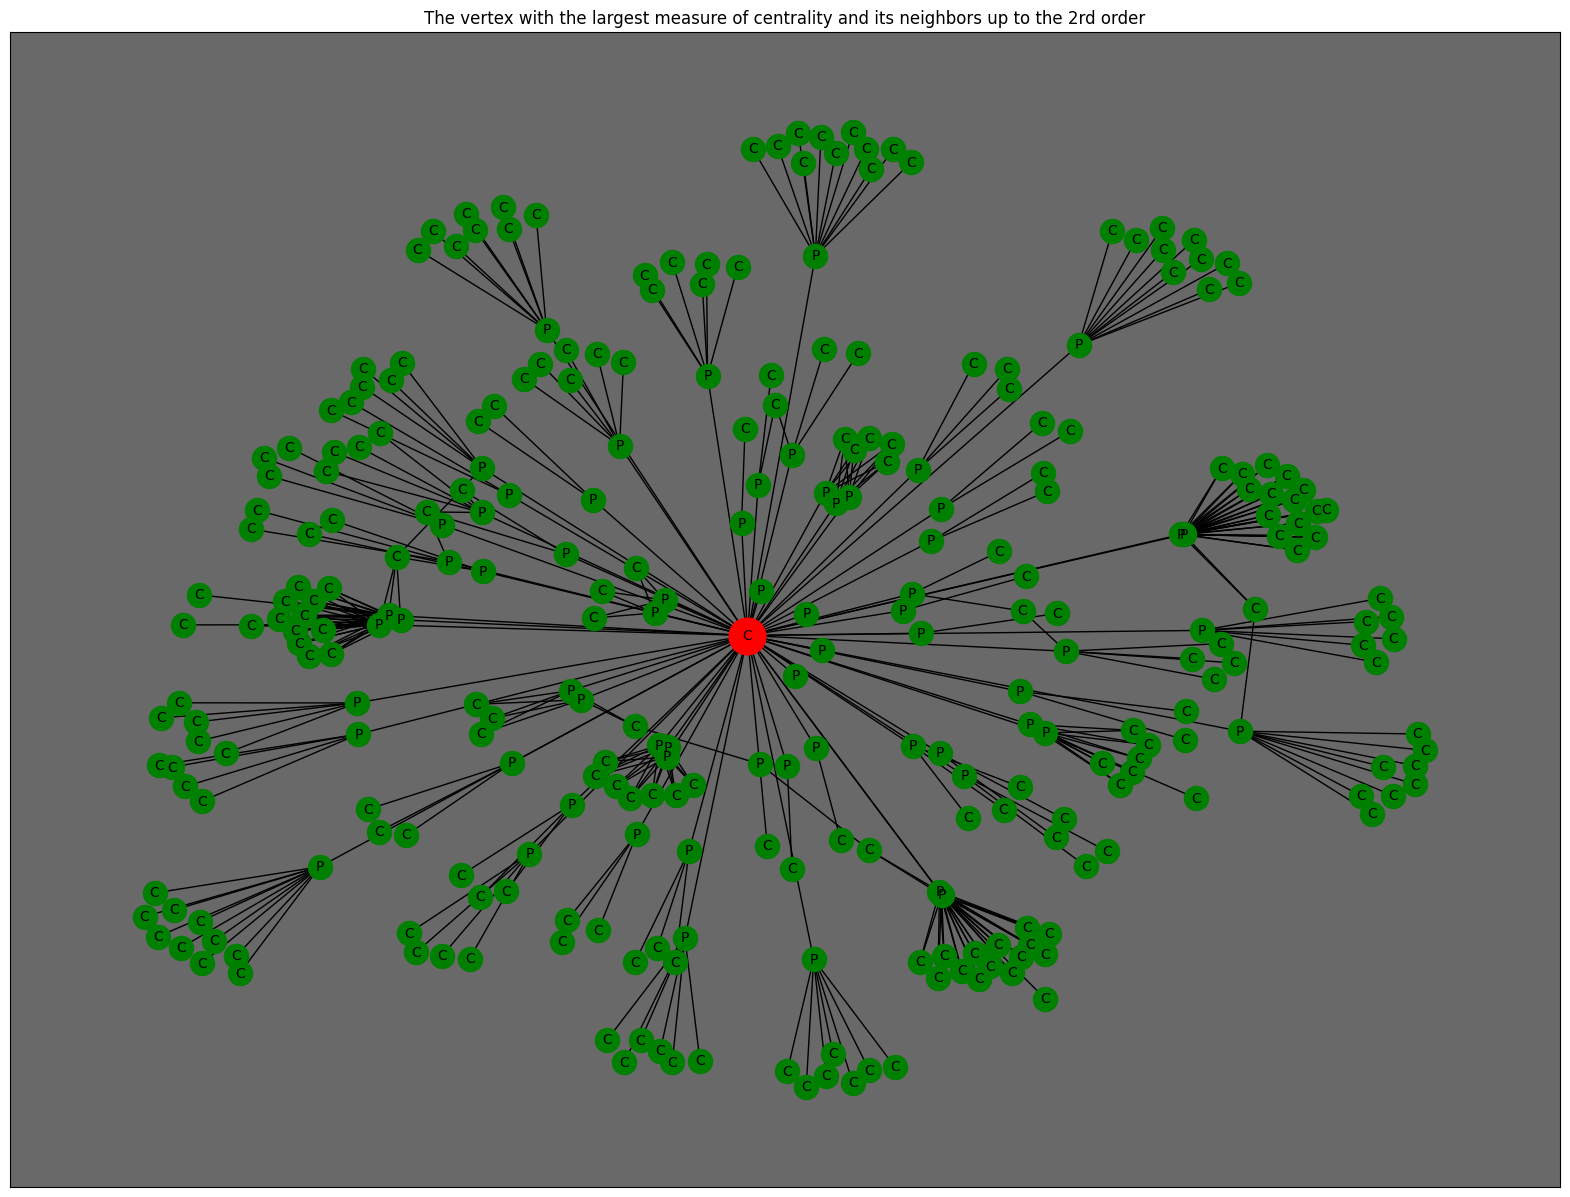

In [124]:
subgraph = G.subgraph(neighbors)

fig, ax = plt.subplots(figsize=(20, 15))
pos = nx.spring_layout(subgraph, k=0.03)
labels = {node:'P' if subgraph.nodes[node]['color'] == person_color else 'C' for node in subgraph.nodes()}

nx.draw_networkx(subgraph, pos, with_labels=True, labels=labels, node_color='green', edge_color='black', font_size=10)


nx.draw_networkx_nodes(subgraph, pos, nodelist=[max_centrality_vertex], node_color='red', node_size=700)

ax.set_facecolor('dimgrey')
plt.title('The vertex with the largest measure of centrality and its neighbors up to the 2rd order')
plt.show()

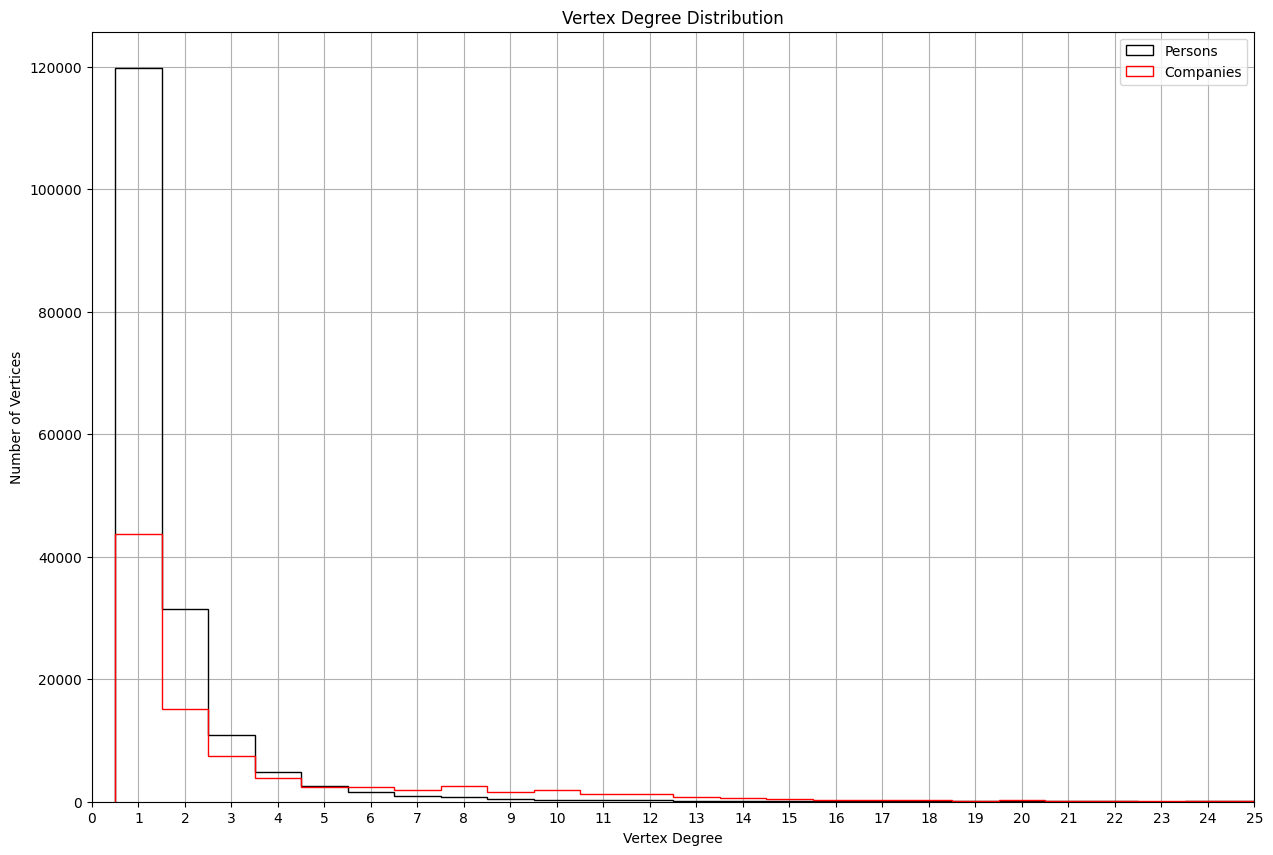

In [ ]:
person_degrees = [degree for node, degree in subgraph.degree()
                  if subgraph.nodes[node]['color'] == person_color]
company_degrees = [degree for node, degree in subgraph.degree()
                  if subgraph.nodes[node]['color'] == company_color]

plt.figure(figsize=(15, 10))

plt.hist(person_degrees, bins=range(min(person_degrees), max(person_degrees) + 1, 1), edgecolor='black', histtype='step', align='left', label='Persons')
plt.hist(company_degrees, bins=range(min(company_degrees), max(company_degrees) + 1, 1), edgecolor='red', histtype='step', align='left', label='Companies')


plt.xlabel('Vertex Degree')
plt.ylabel('Number of Vertices')
plt.title('Vertex Degree Distribution')

plt.grid(True)
plt.xlim((0, 25))
plt.xticks(range(0, 26, 1))
plt.legend()

plt.show()

In [ ]:
print("Max person degree:", max(person_degrees))
print("Max company degree:", max(company_degrees))

Max person degree: 350
Max company degree: 158


## Pattern analysis

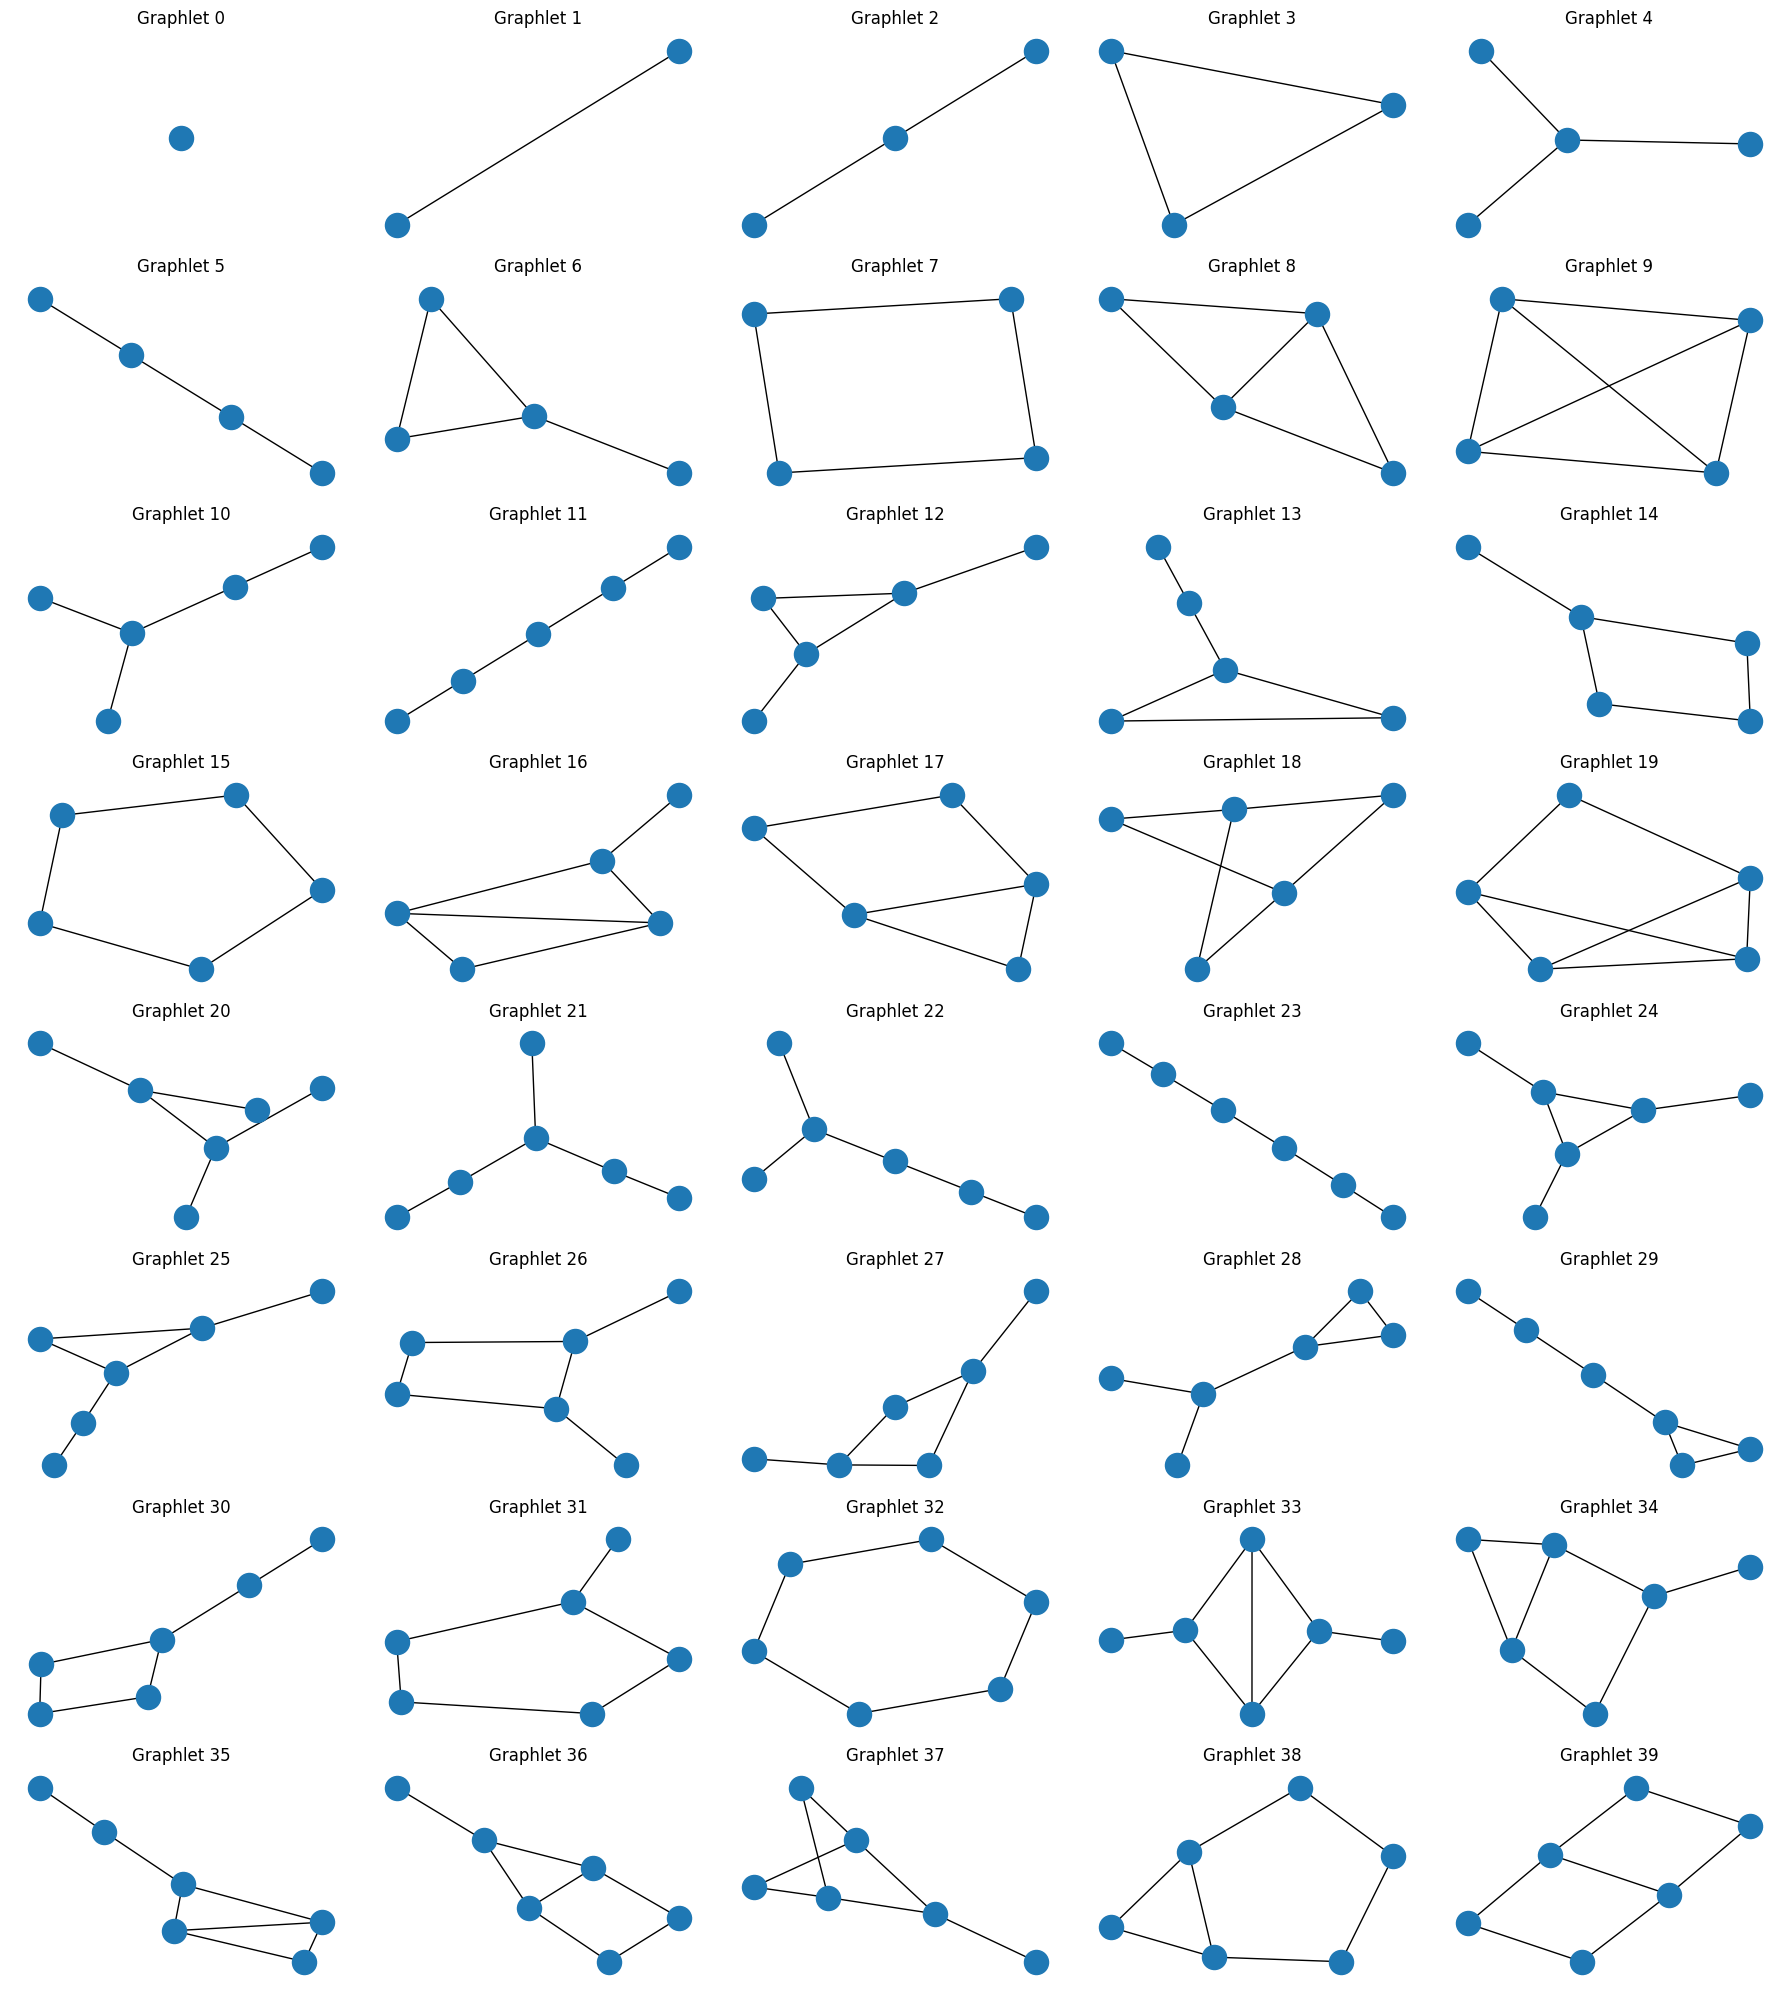

In [ ]:
graphlets = []
for i in range(150):
  g = nx.graph_atlas_g()[i]
  if len([g_p for g_p in nx.connected_components(g)]) == 1:
    degrees = [val for (node, val) in g.degree()]
    if not np.any(np.array(degrees) > 3):
      graphlets.append(g)


fig, axs = plt.subplots(8, 5, figsize=(18, 20))

for i, ax in enumerate(axs.flat):
  nx.draw(graphlets[i], ax=ax)
  ax.set_title(f'Graphlet {i}')

fig.tight_layout()
fig.show()

In [ ]:
graphlets_distribution = np.zeros(len(graphlets))
for nodes in nx.connected_components(G):
  subgraph = G.subgraph(nodes)
  for i in range(len(graphlets)):
    if nx.is_isomorphic(graphlets[i], subgraph):
      graphlets_distribution[i] += 1
      break

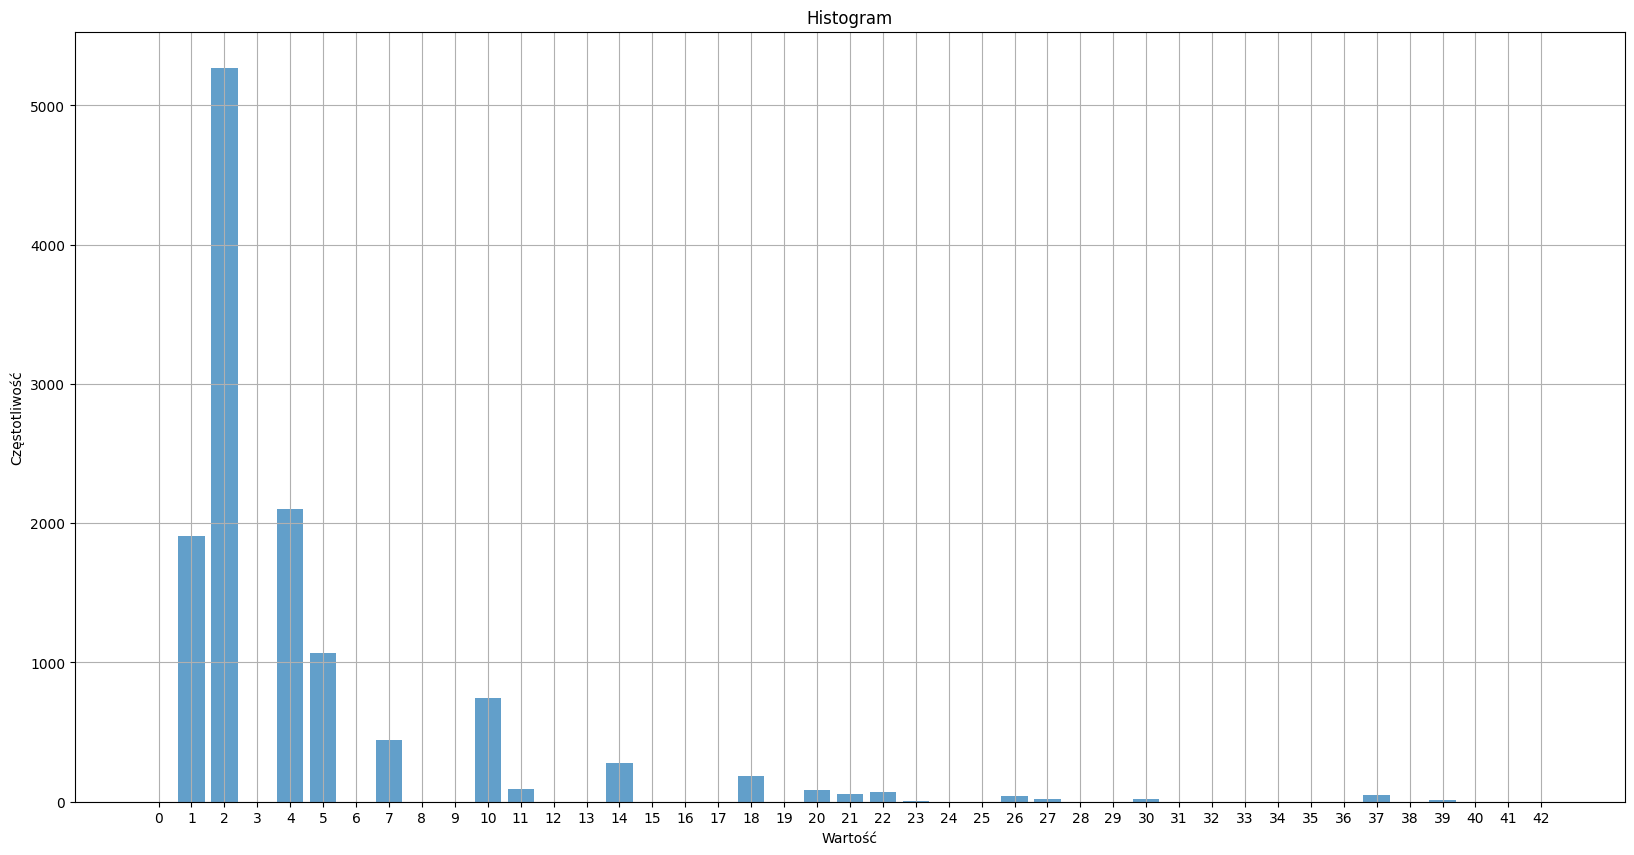

In [ ]:
plt.figure(figsize=(20, 10))
plt.bar(np.arange(len(graphlets_distribution)), graphlets_distribution, align='center', alpha=0.7)

plt.xticks(range(len(graphlets_distribution)), np.arange(0, len(graphlets_distribution)))
plt.xlabel('Wartość')
plt.ylabel('Częstotliwość')
plt.title('Histogram')
plt.grid(True)
plt.show()

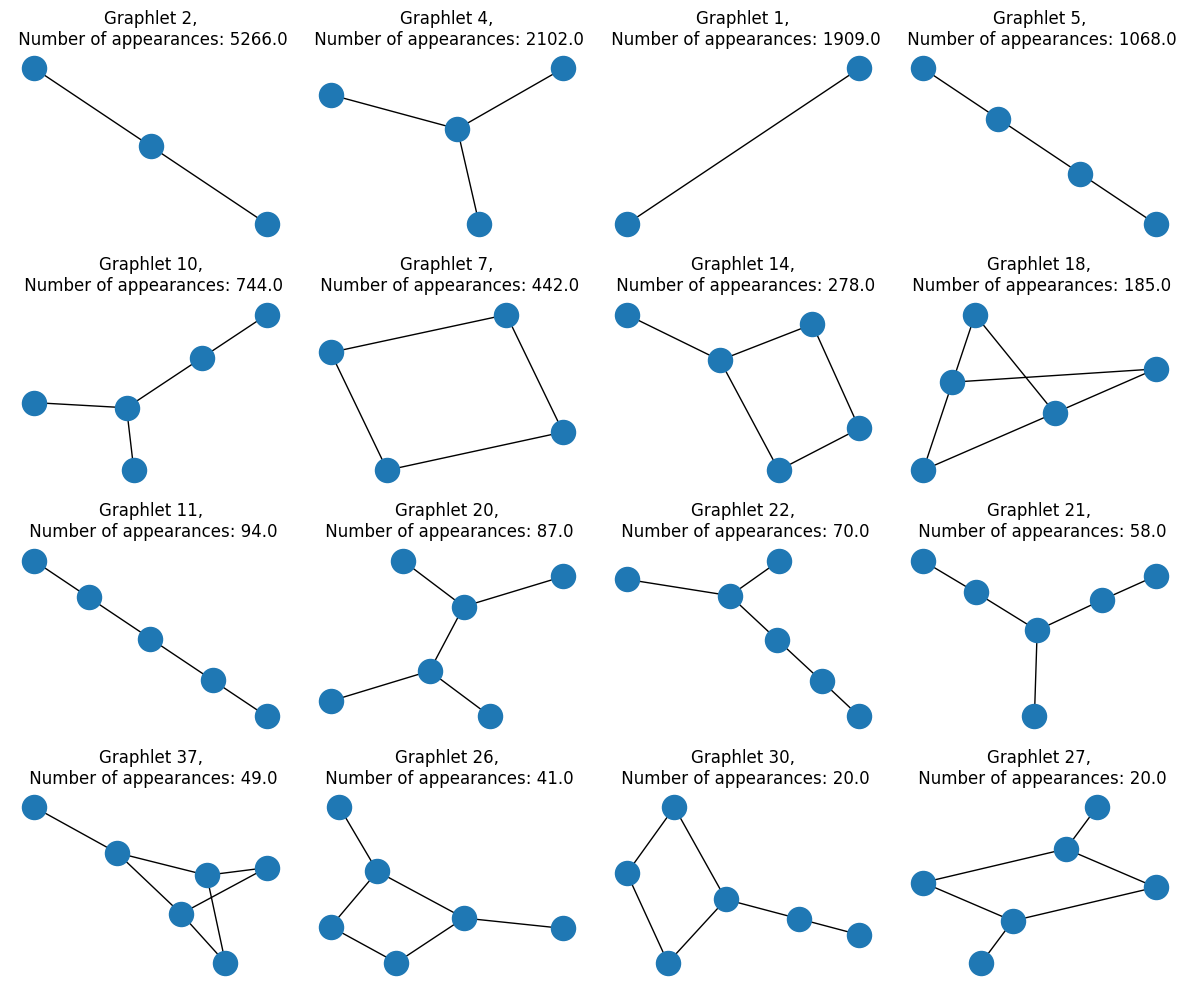

In [ ]:
frequent_graphlets = np.argsort(graphlets_distribution)[::-1]

fig, axs = plt.subplots(4, 4, figsize=(12, 10))


for i, ax in enumerate(axs.flat):
  nx.draw(graphlets[frequent_graphlets[i]], ax=ax)
  ax.set_title(f'Graphlet {frequent_graphlets[i]},\n Number of appearances: {graphlets_distribution[frequent_graphlets[i]]}')

fig.tight_layout()
fig.show()

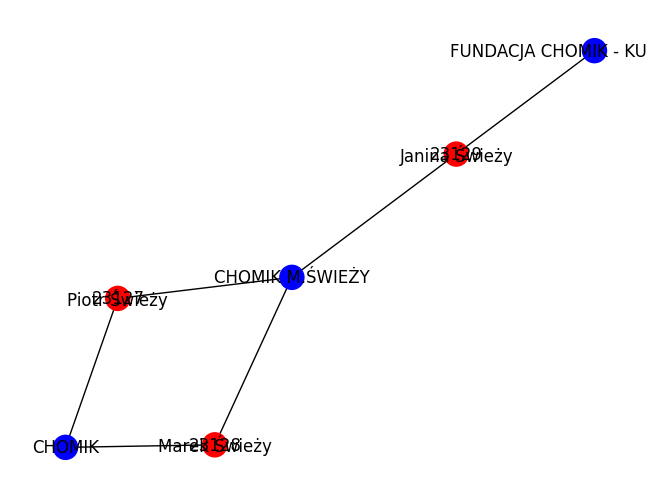

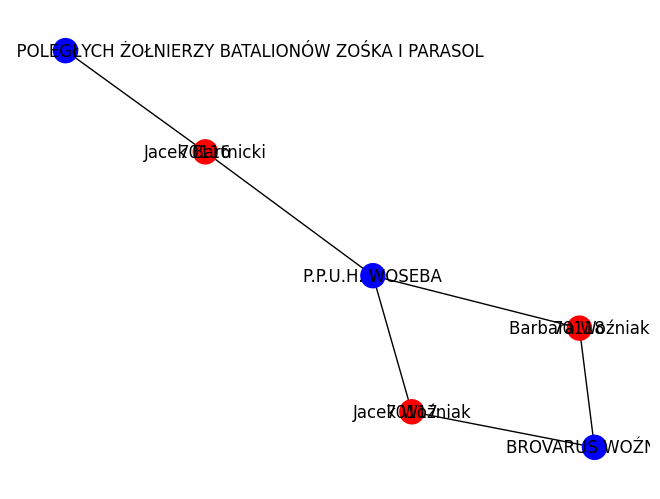

In [ ]:
index = 30 # change index to plot others graphlets examples

graphlet_to_find = graphlets[index]

graphlet_examples = []
for nodes in nx.connected_components(G):
  subgraph = G.subgraph(nodes)
  if nx.is_isomorphic(graphlet_to_find, subgraph):
    graphlet_examples.append(subgraph)
    if len(graphlet_examples) == 3:
      break

if len(graphlet_examples) > 0:
  for graphlet_example in graphlet_examples:
    plt.figure()
    colors = [graphlet_example.nodes[node]['color'] for node in graphlet_example.nodes()]
    pos = nx.spring_layout(graphlet_example)
    nx.draw(graphlet_example, pos, with_labels=True, node_color=colors)
    labels = {node_id: name for node_id, name in nx.get_node_attributes(graphlet_example, 'name').items()}
    nx.draw_networkx_labels(graphlet_example, pos, labels=labels, font_size=12, font_color='black')
    plt.show()
else:
  print("No isomorphic subgraph found")

## Medium graphs

In [23]:
subgraph2_nodes = sorted(nx.connected_components(G), key=len, reverse=True)[3]
subgraph2 = G.subgraph(subgraph2_nodes)

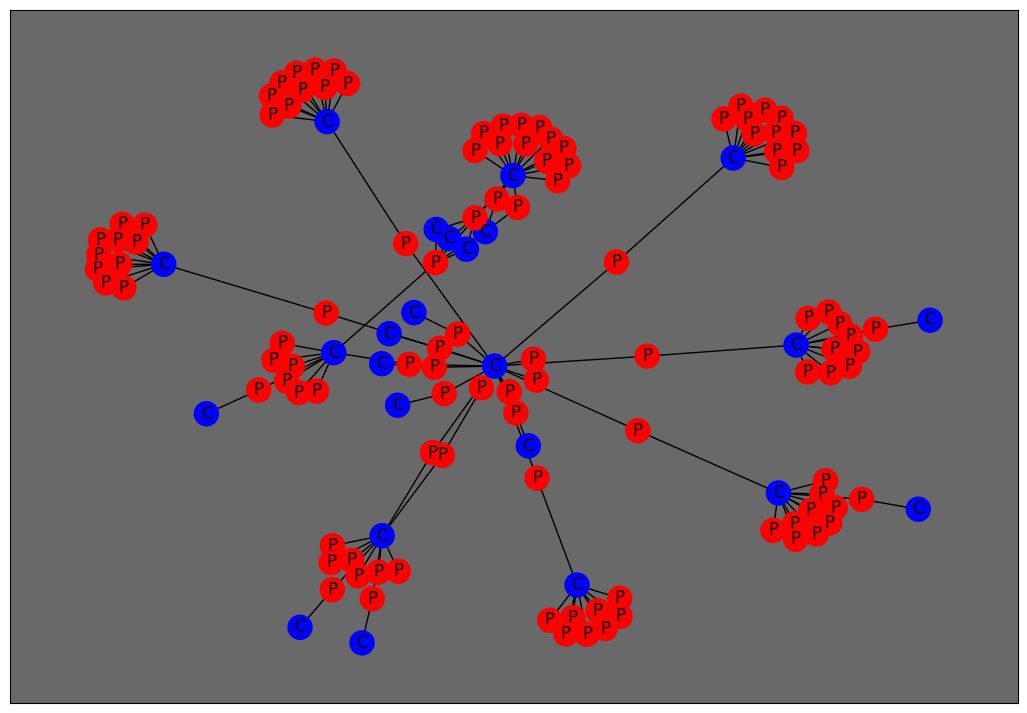

In [116]:
fig, ax = plt.subplots(figsize=(13, 9))
pos = nx.spring_layout(subgraph2)
labels = {node:'P' if subgraph2.nodes[node]['color'] == person_color else 'C' for node in subgraph2.nodes()}
colors = [subgraph2.nodes[node]['color'] for node in subgraph2.nodes()]
nx.draw_networkx(subgraph2, pos=pos, labels=labels, node_color=colors)


ax.set_facecolor('dimgrey')

plt.show()

## Communities

In [ ]:
def find_largest_community(graph):
  com, modularity = [], []
  for communities in nx.algorithms.community.girvan_newman(graph):
    mod = nx.algorithms.community.modularity(graph, communities)
    com.append(communities)
    modularity.append(mod)
  return com, modularity

def main(graphs):
  for i, graph in enumerate(graphs):
    communities, modularity = find_largest_community(graph)
    for i in range(len(modularity)):
      largest_community = max(communities[i], key=len)
      print('runda:', i+1)
      num_nodes = len(largest_community)
      num_edges = graph.subgraph(largest_community).number_of_edges()
      print(f"Największa społeczność: {largest_community}")
      print(f"Liczba wierzchołków: {num_nodes}")
      print(f"Liczba krawędzi: {num_edges}")
      print("Modularity:", modularity[i])
      print()
  return communities, modularity


# Przykładowe wywołanie funkcji main z listą grafów
graphs = [subgraph2]
communities, modularity = main(graphs)


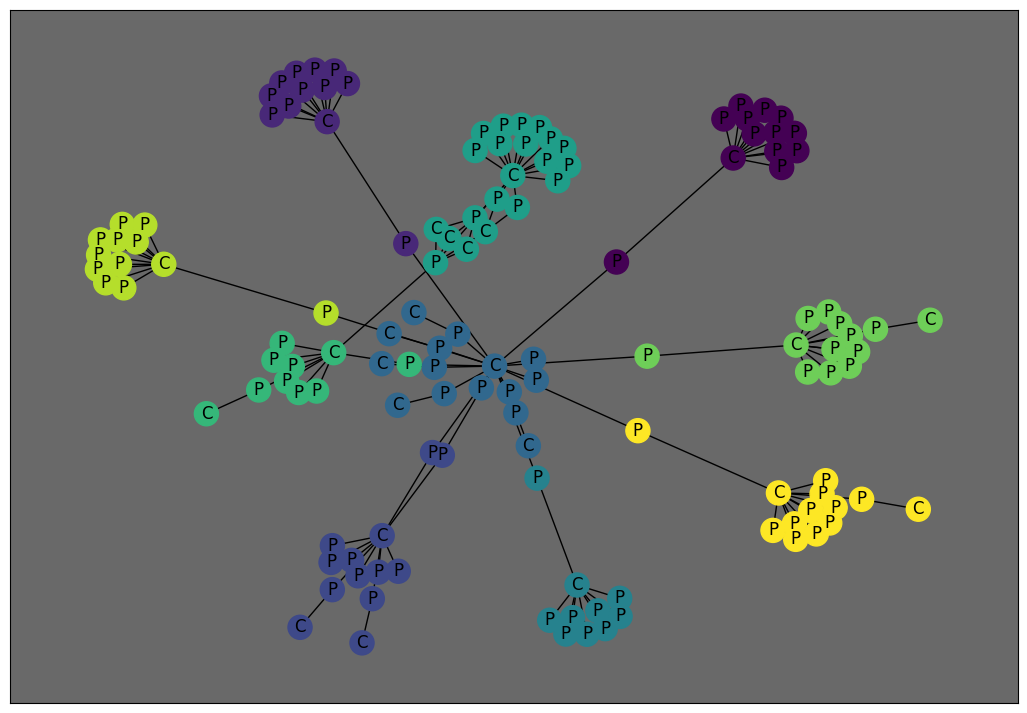

In [117]:
def draw_community_graph_with_positions(graph, communities, original_positions):
  color_map = {}
  for i, community in enumerate(communities):
    for node in community:
        color_map[node] = i

  fig, ax = plt.subplots(figsize=(13, 9))
  labels = {node:'P' if graph.nodes[node]['color'] == person_color else 'C' for node in graph.nodes()}
  nx.draw_networkx(graph, pos=original_positions, labels=labels, node_color=[color_map[node] for node in graph.nodes()])


  ax.set_facecolor('dimgrey')

  plt.show()



mod_max = np.argmax(modularity)

draw_community_graph_with_positions(subgraph2, communities[mod_max], pos)



In [ ]:
nx.write_graphml(G, "graph.graphml")

## Person - Person graph

In [34]:
from itertools import combinations

def nodes_to_edges(graph, nodes):

  for node in nodes:
    neighbors = list(combinations(graph.neighbors(node), 2))
    graph.remove_node(node)
    if neighbors == []:
      continue

    graph.add_edges_from(neighbors)

  return graph

In [35]:
GC = G.copy()
companies = [node for node in GC.nodes() if GC.nodes[node]['color'] == company_color]
PP = nodes_to_edges(GC, companies)



## Cliques

In [37]:
cliques = list(nx.find_cliques(PP))

max_clique_size 158


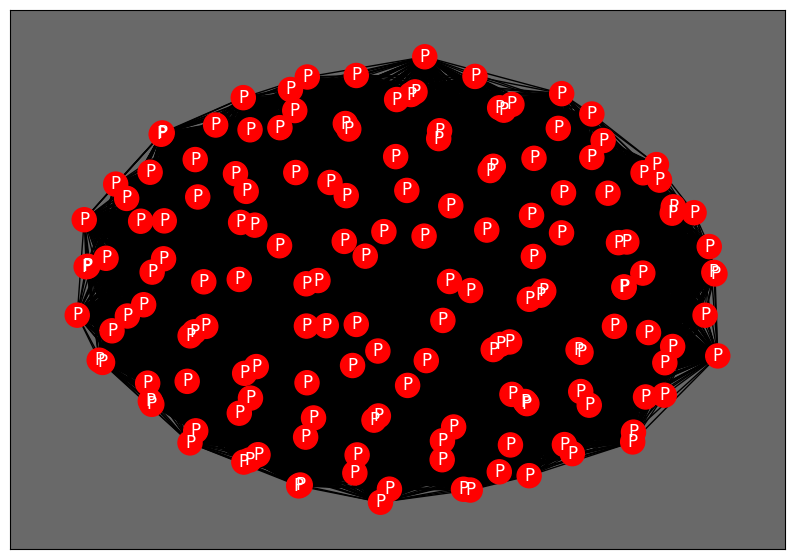

In [110]:
max_clique_size = max(len(clique) for clique in cliques)

largest_cliques = [clique for clique in cliques if len(clique) == max_clique_size]
print("max_clique_size", max_clique_size)


LC = PP.subgraph(largest_cliques[0])

fig, ax = plt.subplots(figsize=(10, 7))

pos = nx.spring_layout(LC)
colors = [LC.nodes[node]['color'] for node in LC.nodes()]
labels = {node:'P' if LC.nodes[node]['color'] == person_color else 'C' for node in LC.nodes()}
nx.draw_networkx(LC, pos, with_labels=True, labels=labels, node_color=colors, edge_color='black', font_color='white')

ax.set_facecolor('dimgrey')
# fig.set_facecolor('dimkgrey')

plt.show()

## Clustering coefficient

In [99]:
subgraph3_nodes = sorted(list(nx.connected_components(PP)), key=len, reverse=True)[121]

subgraph3 = PP.subgraph(subgraph3_nodes)

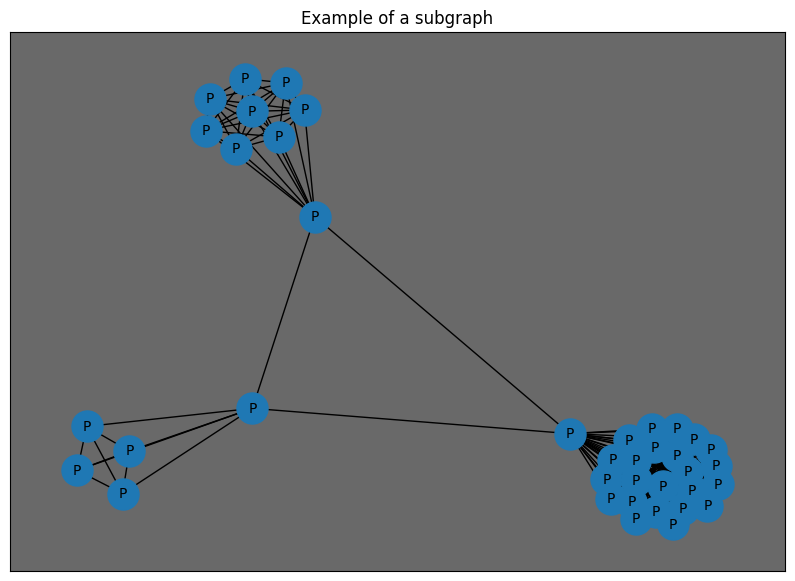

In [126]:

fig, ax = plt.subplots(figsize=(10, 7))
pos = nx.spring_layout(subgraph3)

labels = {node:'P' if subgraph3.nodes[node]['color'] == person_color else 'C' for node in subgraph3.nodes()}
nx.draw_networkx(subgraph3, pos, with_labels=True, labels=labels, edge_color='black', node_size=500, font_size=10)

ax.set_facecolor('dimgrey')
plt.title('Example of a subgraph')
plt.show()

In [105]:
clustering_coefficients = nx.clustering(subgraph3)

values = np.array(list(clustering_coefficients.values()))
min_value, max_value = min(values), max(values)

<ipython-input-129-2142ad2ca446>:9: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Clustering Coefficient')


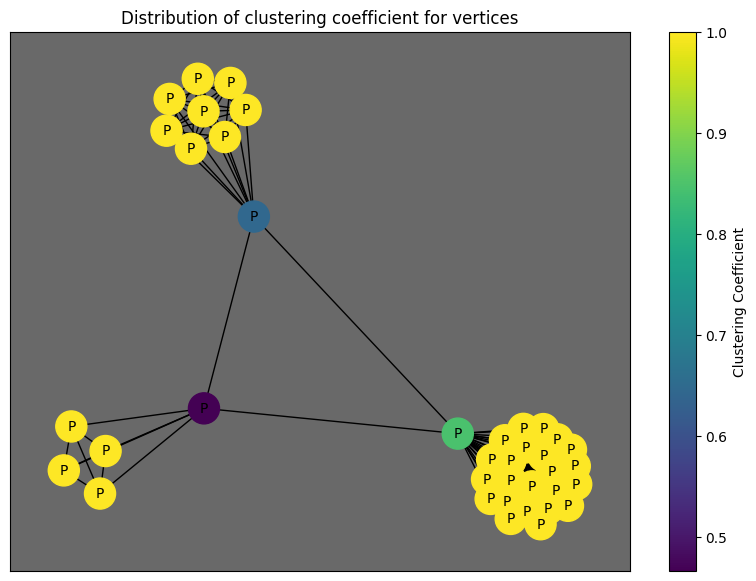

In [129]:
cmap = plt.cm.viridis

fig, ax = plt.subplots(figsize=(10, 7))

nx.draw_networkx(subgraph3, pos, with_labels=True, node_color=values, labels=labels, cmap=cmap, edge_color='black', node_size=500, font_size=10)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_value, vmax=max_value))
sm.set_array([])
plt.colorbar(sm, label='Clustering Coefficient')

ax.set_facecolor('dimgrey')
plt.title('Distribution of clustering coefficient for vertices')
plt.show()